# 19기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

In [490]:
import warnings
warnings.filterwarnings(action='ignore')


---

## 0. 데이터 불러오기

In [491]:
import pandas as pd
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [492]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


In [494]:
df.describe()


,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,4.998000e+03,4998.000000,4998.000000,4998.000000,3465.000000,1544.000000,4998.000000
mean,1.003015e+06,8.036815,0.421369,5.320128,9.773737,12.766839,9234.655462
std,1.709910e+03,6.442697,0.493828,3.912281,5.101867,4.023591,4999.225081
min,1.000003e+06,0.000000,0.000000,1.000000,2.000000,3.000000,13.000000
25%,1.001560e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5497.750000
50%,1.003040e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8049.000000
75%,1.004417e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12039.000000
max,1.006037e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23913.000000


In [495]:
df.isnull().sum()


User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

Product Category_2,3의 경우 결측값이 존재하므로 결측치를 처리하는 과정이 필요
knn을 구현을 하기 위해서는 기본적으로 '거리 기반'이기 때문에, categorical 변수들에 대해서는 원핫 인코딩을 해주어야함.(후에 원핫인코딩 진행)


Fill Missing DATA

In [496]:
null_3= (df['Product_Category_3'].isnull().sum()/len(df['Product_Category_3'])).round(2)
null_2= (df['Product_Category_2'].isnull().sum()/len(df['Product_Category_2'])).round(2)
print(null_2, null_3)


0.31 0.69


Product_Category_2의 경우에는 31% 정도가 null값이고,

Proudct_Category_3의 경우에는 69% 정도가 null값이다.

Empirical한 guideline에 의하여, product_category_3의 경우 drop하는 것이 좋을 것이고, product_category_2의 경우에는 imputer을 사용한다

In [497]:
df=df.drop(columns=['User_ID','Product_Category_3'])


Imputer

In [498]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer( strategy='most_frequent')
imput_arr=imputer.fit_transform(df)


In [499]:
df=pd.DataFrame(data=imput_arr, columns=df.columns)
df

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00046042,F,0-17,10,A,3,0,5,17.0,2010
1,P00347742,F,0-17,10,A,1,0,7,8.0,4483
2,P00048942,F,0-17,10,A,1,0,1,4.0,7696
3,P00145242,F,0-17,10,A,3,0,2,4.0,16429
4,P00106742,F,0-17,10,A,3,0,3,5.0,5780
...,...,...,...,...,...,...,...,...,...,...
4993,P00147942,M,55+,7,C,1,1,1,16.0,11701
4994,P00358242,M,55+,1,C,1,1,8,8.0,2045
4995,P00173342,M,55+,13,C,3,1,1,6.0,4505
4996,P00336742,M,55+,0,C,2,1,12,8.0,1413


In [500]:
df.isnull().sum()

Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Purchase                      0
dtype: int64

#결측치 처리 완료

In [501]:
df[["Occupation", "Marital_Status","Purchase","Product_Category_1","Product_Category_2"]] = df[["Occupation", "Marital_Status","Purchase","Product_Category_1","Product_Category_2"]].apply(pd.to_numeric)
df

,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,P00046042,F,0-17,10,A,3,0,5,17.0,2010
1,P00347742,F,0-17,10,A,1,0,7,8.0,4483
2,P00048942,F,0-17,10,A,1,0,1,4.0,7696
3,P00145242,F,0-17,10,A,3,0,2,4.0,16429
4,P00106742,F,0-17,10,A,3,0,3,5.0,5780
...,...,...,...,...,...,...,...,...,...,...
4993,P00147942,M,55+,7,C,1,1,1,16.0,11701
4994,P00358242,M,55+,1,C,1,1,8,8.0,2045
4995,P00173342,M,55+,13,C,3,1,1,6.0,4505
4996,P00336742,M,55+,0,C,2,1,12,8.0,1413


In [502]:
df=df.drop(columns='Product_ID')


In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      4998 non-null   object 
 1   Age                         4998 non-null   object 
 2   Occupation                  4998 non-null   int64  
 3   City_Category               4998 non-null   object 
 4   Stay_In_Current_City_Years  4998 non-null   object 
 5   Marital_Status              4998 non-null   int64  
 6   Product_Category_1          4998 non-null   int64  
 7   Product_Category_2          4998 non-null   float64
 8   Purchase                    4998 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 351.5+ KB


이상치 탐지

array([[<AxesSubplot:title={'center':'Occupation'}>,
        <AxesSubplot:title={'center':'Marital_Status'}>],
       [<AxesSubplot:title={'center':'Product_Category_1'}>,
        <AxesSubplot:title={'center':'Product_Category_2'}>],
       [<AxesSubplot:title={'center':'Purchase'}>, <AxesSubplot:>]],
      dtype=object)

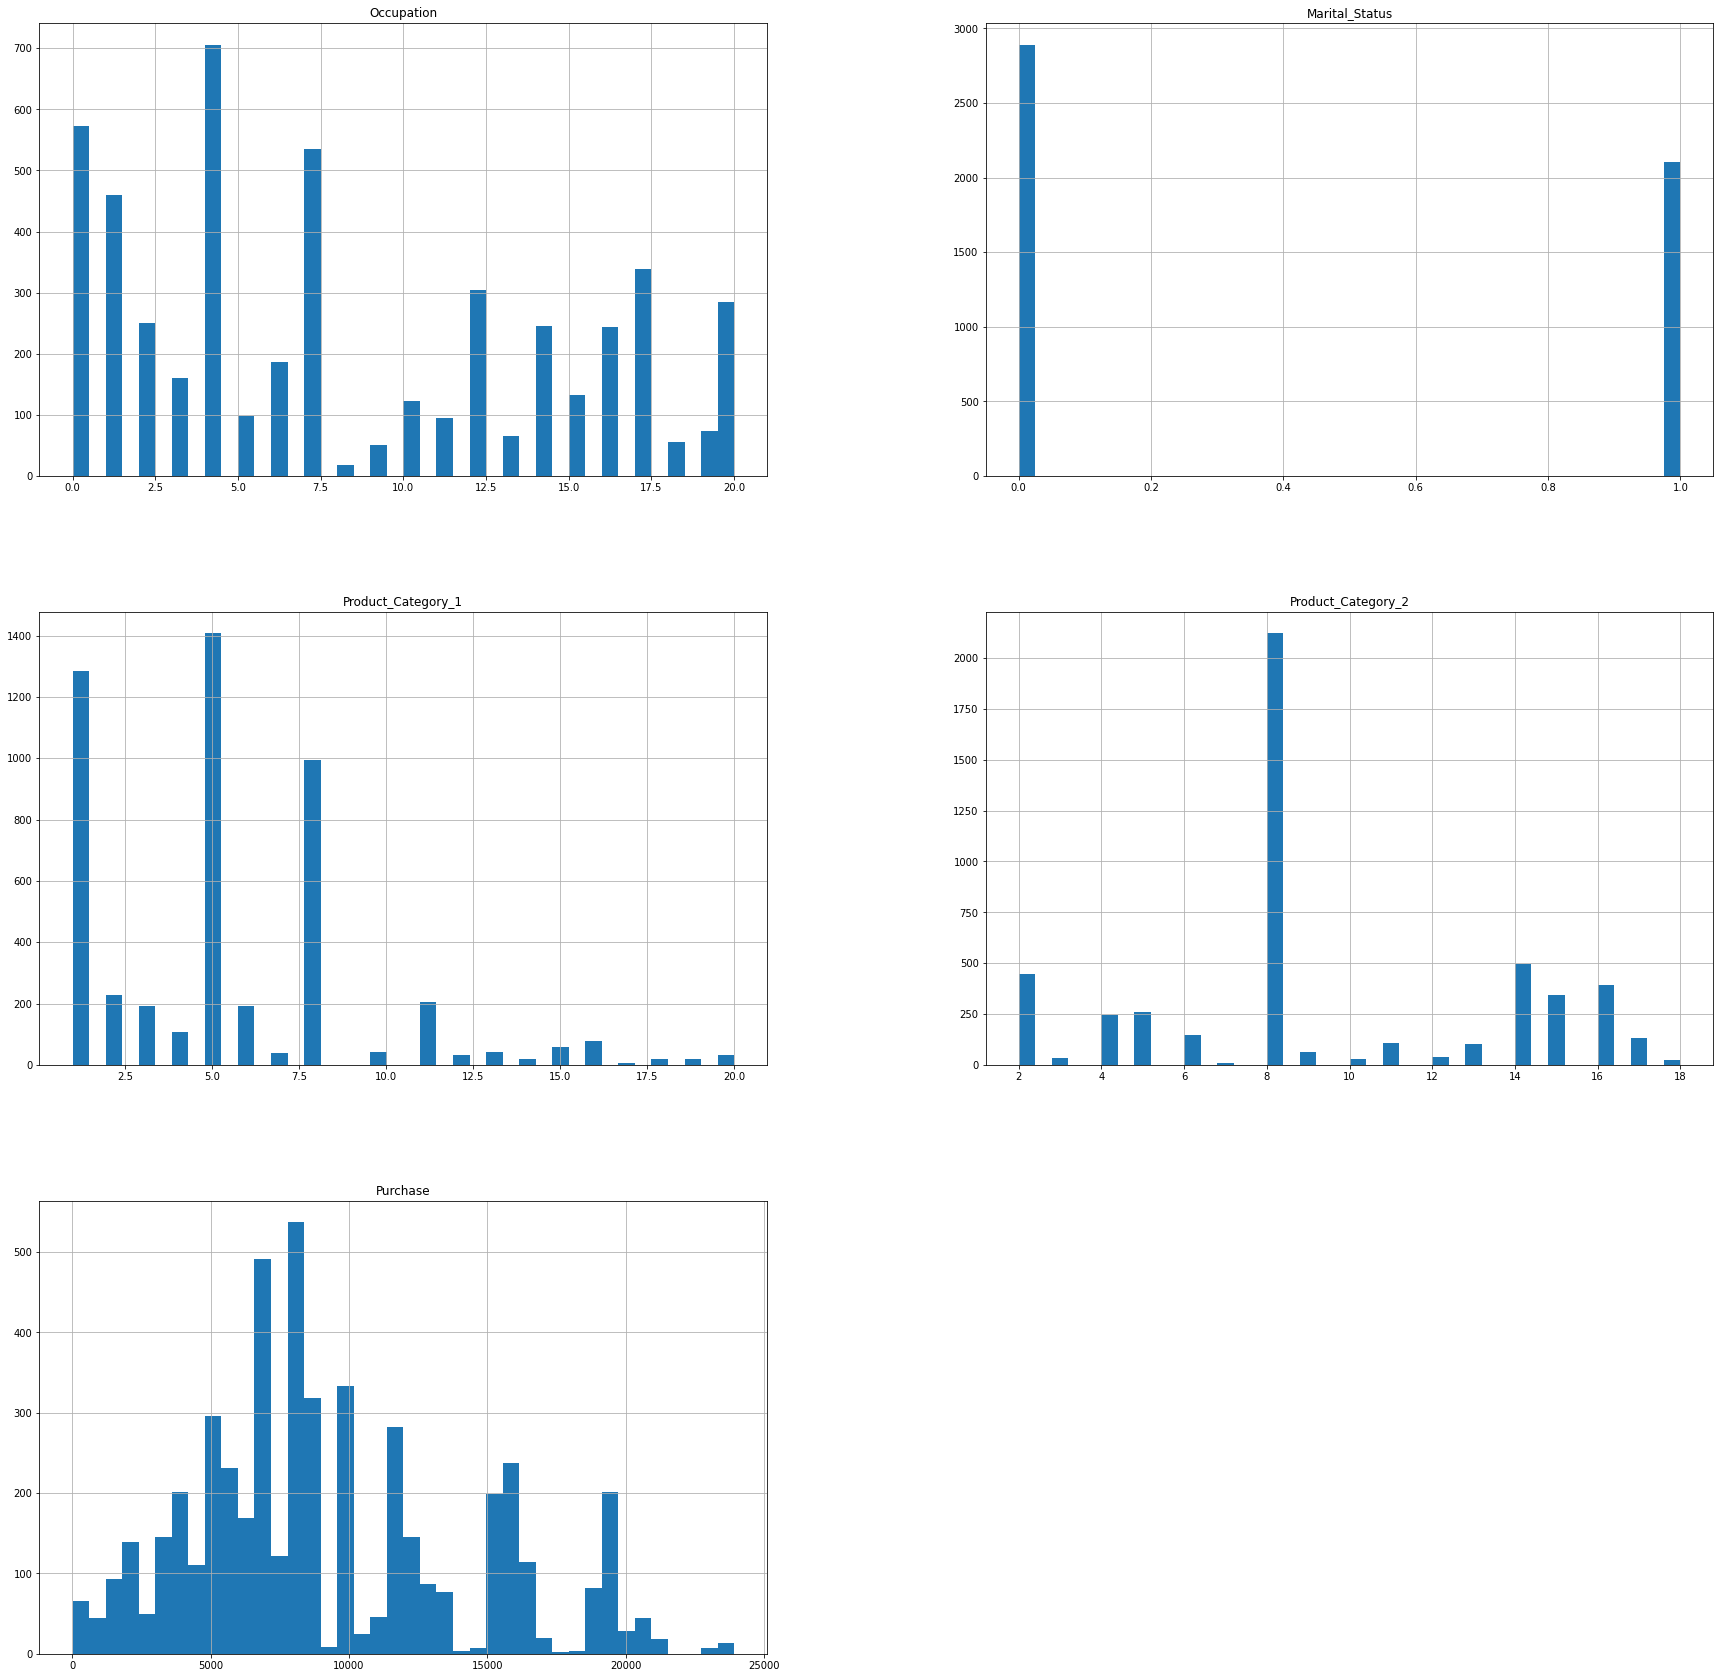

In [504]:
df.hist(bins=40, figsize=(30,30))

이상치X

EDA

상관관계분석

<AxesSubplot:>

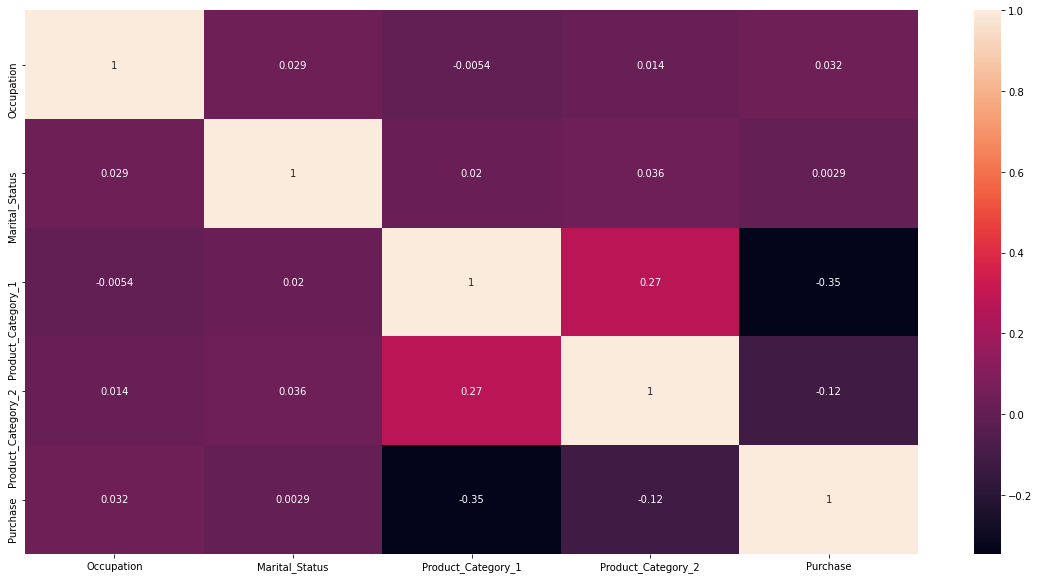

In [505]:
plt.figure(1,figsize=(20,10))
sns.heatmap(df.corr(),annot=True)

Categorical Column들에 대한 countplot 도식화

<AxesSubplot:xlabel='Gender', ylabel='count'>

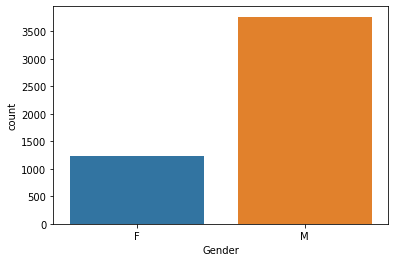

In [506]:
sns.countplot(df['Gender'])

남성 구매자가 더 많음..

<AxesSubplot:xlabel='Marital_Status', ylabel='count'>

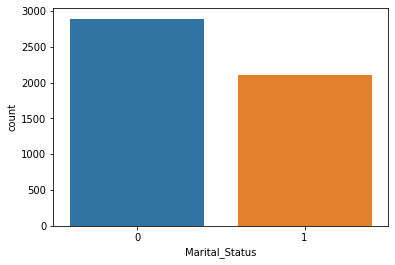

In [507]:
sns.countplot(df['Marital_Status'])

<AxesSubplot:xlabel='Age', ylabel='count'>

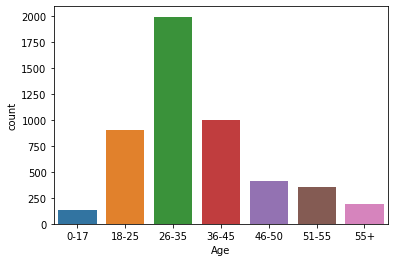

In [508]:
sns.countplot(df['Age'])


<AxesSubplot:xlabel='Occupation', ylabel='count'>

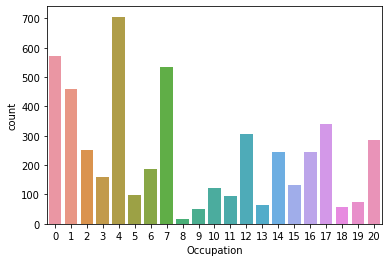

In [509]:
sns.countplot(df['Occupation'])
#occupation이 모두 다른 숫자로 encoded 되어 있음

<AxesSubplot:xlabel='City_Category', ylabel='count'>

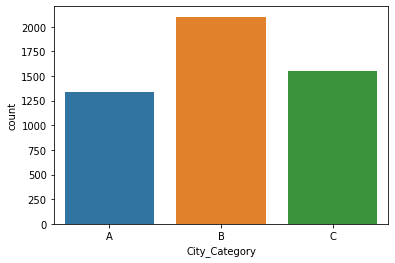

In [510]:
sns.countplot(df['City_Category'])

<AxesSubplot:xlabel='Stay_In_Current_City_Years', ylabel='count'>

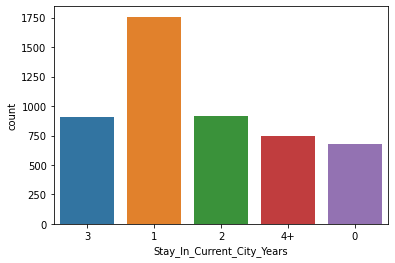

In [511]:
sns.countplot(df['Stay_In_Current_City_Years'])

<AxesSubplot:xlabel='City_Category', ylabel='count'>

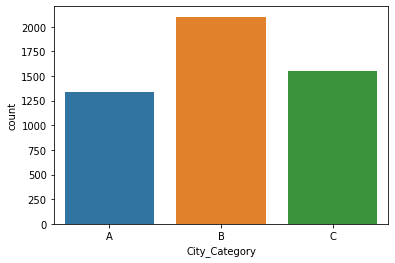

In [512]:
sns.countplot(df['City_Category'])

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

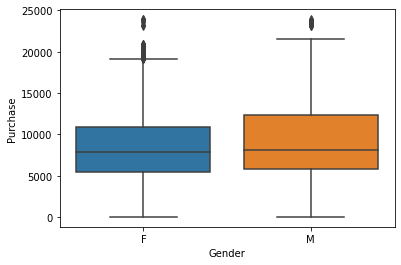

In [513]:
sns.boxplot(x=df['Gender'],y=df['Purchase'])

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

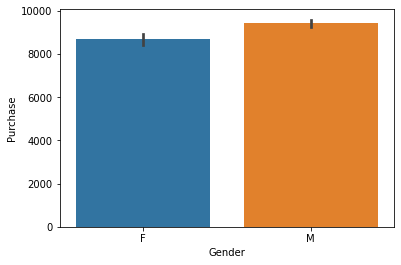

In [514]:
sns.barplot(x=df['Gender'],y=df['Purchase'])

범주형 변수들 원핫 인코딩

In [515]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Purchase'],
      dtype='object')

In [516]:
df.dtypes

Gender                         object
Age                            object
Occupation                      int64
City_Category                  object
Stay_In_Current_City_Years     object
Marital_Status                  int64
Product_Category_1              int64
Product_Category_2            float64
Purchase                        int64
dtype: object

In [517]:
df['Stay_In_Current_City_Years']=df['Stay_In_Current_City_Years'].apply(lambda x: 4 if x=='4+' else x)
df['Stay_In_Current_City_Years'].value_counts()

1    1758
2     915
3     908
4     742
0     675
Name: Stay_In_Current_City_Years, dtype: int64

In [518]:
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
0,F,0-17,10,A,3,0,5,17.0,2010
1,F,0-17,10,A,1,0,7,8.0,4483
2,F,0-17,10,A,1,0,1,4.0,7696
3,F,0-17,10,A,3,0,2,4.0,16429
4,F,0-17,10,A,3,0,3,5.0,5780
...,...,...,...,...,...,...,...,...,...
4993,M,55+,7,C,1,1,1,16.0,11701
4994,M,55+,1,C,1,1,8,8.0,2045
4995,M,55+,13,C,3,1,1,6.0,4505
4996,M,55+,0,C,2,1,12,8.0,1413


In [519]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Gender                      4998 non-null   object 
 1   Age                         4998 non-null   object 
 2   Occupation                  4998 non-null   int64  
 3   City_Category               4998 non-null   object 
 4   Stay_In_Current_City_Years  4998 non-null   object 
 5   Marital_Status              4998 non-null   int64  
 6   Product_Category_1          4998 non-null   int64  
 7   Product_Category_2          4998 non-null   float64
 8   Purchase                    4998 non-null   int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 351.5+ KB


In [520]:
df = df.astype({'Marital_Status':'O'}) # 타입 변환


In [521]:
cat_cols=['Marital_Status','Stay_In_Current_City_Years','Age','Occupation', 'City_Category','Product_Category_1','Product_Category_2']

df=pd.get_dummies(df,columns=cat_cols,drop_first=True)
df


,Gender,Purchase,Marital_Status_1,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Age_18-25,Age_26-35,Age_36-45,...,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0
0,F,2010,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,F,4483,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,F,7696,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,F,16429,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,F,5780,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,M,11701,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4994,M,2045,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4995,M,4505,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4996,M,1413,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [522]:
df.columns

Index(['Gender', 'Purchase', 'Marital_Status_1',
       'Stay_In_Current_City_Years_0', 'Stay_In_Current_City_Years_1',
       'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3',
       'Age_18-25', 'Age_26-35', 'Age_36-45', 'Age_46-50', 'Age_51-55',
       'Age_55+', 'Occupation_1', 'Occupation_2', 'Occupation_3',
       'Occupation_4', 'Occupation_5', 'Occupation_6', 'Occupation_7',
       'Occupation_8', 'Occupation_9', 'Occupation_10', 'Occupation_11',
       'Occupation_12', 'Occupation_13', 'Occupation_14', 'Occupation_15',
       'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19',
       'Occupation_20', 'City_Category_B', 'City_Category_C',
       'Product_Category_1_2', 'Product_Category_1_3', 'Product_Category_1_4',
       'Product_Category_1_5', 'Product_Category_1_6', 'Product_Category_1_7',
       'Product_Category_1_8', 'Product_Category_1_9', 'Product_Category_1_10',
       'Product_Category_1_11', 'Product_Category_1_12',
       'Product_Cate

Split and Apply KNN

In [523]:
from sklearn.model_selection import train_test_split
X = df.drop('Gender',axis=1)
y = df['Gender']

In [524]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [525]:
X_train.columns

Index(['Purchase', 'Marital_Status_1', 'Stay_In_Current_City_Years_0',
       'Stay_In_Current_City_Years_1', 'Stay_In_Current_City_Years_2',
       'Stay_In_Current_City_Years_3', 'Age_18-25', 'Age_26-35', 'Age_36-45',
       'Age_46-50', 'Age_51-55', 'Age_55+', 'Occupation_1', 'Occupation_2',
       'Occupation_3', 'Occupation_4', 'Occupation_5', 'Occupation_6',
       'Occupation_7', 'Occupation_8', 'Occupation_9', 'Occupation_10',
       'Occupation_11', 'Occupation_12', 'Occupation_13', 'Occupation_14',
       'Occupation_15', 'Occupation_16', 'Occupation_17', 'Occupation_18',
       'Occupation_19', 'Occupation_20', 'City_Category_B', 'City_Category_C',
       'Product_Category_1_2', 'Product_Category_1_3', 'Product_Category_1_4',
       'Product_Category_1_5', 'Product_Category_1_6', 'Product_Category_1_7',
       'Product_Category_1_8', 'Product_Category_1_9', 'Product_Category_1_10',
       'Product_Category_1_11', 'Product_Category_1_12',
       'Product_Category_1_13', 'Prod

In [526]:
X_test.isnull().sum()

Purchase                        0
Marital_Status_1                0
Stay_In_Current_City_Years_0    0
Stay_In_Current_City_Years_1    0
Stay_In_Current_City_Years_2    0
                               ..
Product_Category_2_14.0         0
Product_Category_2_15.0         0
Product_Category_2_16.0         0
Product_Category_2_17.0         0
Product_Category_2_18.0         0
Length: 69, dtype: int64

Scaling

In [527]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train['Purchase'].values.reshape(-1,1))
train_scaled = ss.transform(X_train['Purchase'].values.reshape(-1,1))
test_scaled=ss.transform(X_test['Purchase'].values.reshape(-1,1))

X_train['Purchase']=train_scaled
X_test['Purchase']=test_scaled









In [528]:
X_train

,Purchase,Marital_Status_1,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Age_18-25,Age_26-35,Age_36-45,Age_46-50,...,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0
1738,-1.039145,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3986,-1.452809,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2915,1.263448,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1595,-0.067941,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3213,-0.234165,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,-0.263299,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
466,-0.465642,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3092,-0.461850,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3772,-0.221793,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [529]:
X_test

,Purchase,Marital_Status_1,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Age_18-25,Age_26-35,Age_36-45,Age_46-50,...,Product_Category_2_9.0,Product_Category_2_10.0,Product_Category_2_11.0,Product_Category_2_12.0,Product_Category_2_13.0,Product_Category_2_14.0,Product_Category_2_15.0,Product_Category_2_16.0,Product_Category_2_17.0,Product_Category_2_18.0
84,-0.507148,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2470,-0.756983,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2803,0.501970,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4986,-0.099869,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4923,0.466451,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4522,-0.272478,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1918,2.360966,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3862,-0.180486,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4198,-0.364071,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [530]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier() 
knn.fit(X_train, y_train)
print("Test Score : {:.3f}".format(knn.score(X_test, y_test)))

Test Score : 0.743


In [531]:
from sklearn import metrics

k_list = range(1, 21)

scores = []

# We append the scores in the dictionary
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Accuracy')

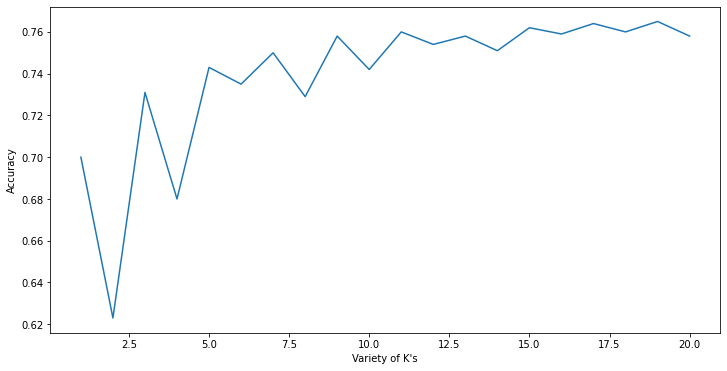

In [532]:
plt.figure(figsize=(12, 6))
plt.plot(k_list, scores)
plt.xlabel("Variety of K's")
plt.ylabel('Accuracy')

In [533]:
scores = np.array(scores)
top_idx = np.argmax(scores)
print(top_idx, scores[top_idx])

18 0.765


거리가중치 사용

In [534]:
knn = KNeighborsClassifier(n_neighbors=18, weights='distance')
knn.fit(X_train, y_train)
print("Test Score : {:.3f}".format(knn.score(X_test, y_test)))

Test Score : 0.768


소폭 증가